In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install opencv-python-headless
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import numpy as np
from skimage import feature, exposure
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import json
import matplotlib.pyplot as plt

# 데이터 준비


In [48]:
import os
import cv2
import json
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 이미지와 라벨링 데이터의 경로를 지정합니다.
image_data_folder = 'C:\\Users\\ewqds\\Documents\\Pill_Data\\1.Training\\image\\'
label_data_folder = 'C:\\Users\\ewqds\\Documents\\Pill_Data\\1.Training\\Label\\'

# 학습 및 테스트 데이터를 저장할 리스트를 생성합니다.
X = []  # 이미지 데이터
y = []  # 라벨 데이터
count = 0
# 이미지 폴더에서 파일 이름을 반복하여 데이터를 로드합니다.
for image_code_name in os.listdir(image_data_folder):
    count += 10
    # 이미지 파일의 전체 경로
    image_file_path = os.path.join(image_data_folder, image_code_name)
    label_file_path= os.path.join(label_data_folder, image_code_name)
    # print("ds: ", os.listdir(image_file_path))
    # print(os.listdir(label_file_path))
    print("===================", str(count) + "% 완료 ===================")
    for image in os.listdir(image_file_path):
        # 라벨 파일의 전체 image_label_path
        image_path = os.path.join(image_file_path,image)
        label_path = os.path.join(label_file_path, image[:-4]+'.json')
        
        # 이미지를 로드합니다. 
        image = cv2.imread(image_path)
        if image is None:
            print("못불러옴")  # 이미지를 로드하지 못한 경우 건너뜁니다.
        
        # 라벨 데이터를 로드합니다.
        with open(label_path, 'r') as label_file:
            label_data = json.load(label_file)
        
        # 라벨 데이터에서 분류 라벨을 추출합니다. (예: 'Normal' 또는 'Abnormal')
        label = label_data['images'][0]['drug_N']


        #===================경게 상자 좌표 추출 작업===================#
        # 라벨링 데이터에서 경계 상자 좌표 추출
        bbox = label_data['annotations'][0]['bbox']
        width, length, w, h = bbox

        # 이미지에서 알약 부분 잘라내기
        pill_cropped = image[length:length+h, width:width+w]

        # 잘라낸 이미지의 크기를 확인하고, 필요한 경우 크기를 조정합니다.
        pill_resized = cv2.resize(pill_cropped, (227, 227))
        #============================================================#


        # # 이미지와 라벨을 리스트에 추가합니다.
        # X.append(pill_resized)
        # y.append(label)
        #===================Data preprocessing===================#
        
        # 이미지를 그레이스케일로 변환
        gray = cv2.cvtColor(pill_resized, cv2.COLOR_BGR2GRAY)

        # 가우시안 필터를 적용하여 블러 처리
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        # 평균 필터 적용
        mean_filtered = cv2.blur(blurred, (5, 5))

        # 히스토그램 평활화
        equalized = cv2.equalizeHist(mean_filtered)

        # Sobel 필터를 사용한 형태 감지
        sobelx = cv2.Sobel(mean_filtered, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(mean_filtered, cv2.CV_64F, 0, 1, ksize=5)
        sobel = cv2.magnitude(sobelx, sobely)
        # 임계값 적용하여 이진 이미지 생성
        _, thresholded = cv2.threshold(sobel, 50, 255, cv2.THRESH_BINARY)

        # Canny 에지 검출기 사용
        canny_edges = cv2.Canny(np.uint8(thresholded), 100, 200)
        # Dilution 작업
        dilated = cv2.dilate(canny_edges, np.ones((5,5), np.uint8), iterations=1)

        # SIFT 및 MLBP (예시로 SIFT만 구현, MLBP는 OpenCV에서 직접적으로 지원하지 않음)
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(dilated, None)
        # 결과 이미지 반환 (SIFT 키포인트로 표시된 이미지를 반환합니다)
        result_image = cv2.drawKeypoints(dilated, keypoints, None)

        # cv2.imshow('Processed Image', processed_image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        # OpenCV로 이미지를 BGR에서 RGB로 변환
        processed_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
        
        
        # # 결과 시각화
        # plt.figure(figsize=(5, 5))
        # plt.subplot(331), plt.imshow(blurred_image, cmap='gray'), plt.title('Gaussian Blur Blur')
        # plt.subplot(332), plt.imshow(smoothed_image, cmap='gray'), plt.title('Mean Filter')
        # plt.subplot(333), plt.imshow(equalized_image, cmap='gray'), plt.title('Histogram Equalization')
        # plt.subplot(334), plt.imshow(equalized_image, cmap='gray'), plt.title('Histogram Equalization')
        # plt.subplot(335), plt.imshow(sobel_edges, cmap='gray'), plt.title('Sobel edges')
        # plt.subplot(336), plt.imshow(binary_image, cmap='gray'), plt.title('Segmented shape')
        # plt.subplot(337), plt.imshow(canny_edges, cmap='gray'), plt.title('Canny edges')
        # plt.subplot(338), plt.imshow(dilution_img, cmap='gray'), plt.title('Dilated Edges')
        # plt.subplot(339), plt.imshow(sift_image, cmap='gray'), plt.title('SIFT image')


        #============================================================#
        #======================Datfa Reshaping========================#

        # # 이미지를 모델 입력 크기로 리사이즈합니다.
        # binary_image_rgb = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)
        # resized_images = [cv2.resize(img, (227, 227)) for img in [binary_image_rgb, sift_image]]

        # # 이미지들을 하나의 배치로 결합합니다.
        # # 추가 차원을 추가하여 4D 텐서로 만듭니다: (samples, height, width, channels)
        # batch_images = np.stack(resized_images, axis=0)
        # #============================================================#

        # 이미지와 라벨을 리스트에 추가합니다.
        X.append(processed_image_rgb)  #RGB 차원의 data
        y.append(label)


# ss리스트를 numpy 배열로 변환합니다.
X = np.array(X)
y = np.array(y)
# # 잘라낸 알약 이미지를 시각화합니다.
# plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))
# plt.show()

# 이후 모델 학습 코드를 작성합니다.
# 예:
# model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

=================== 10% 완료 ===================
=================== 20% 완료 ===================
=================== 30% 완료 ===================
=================== 40% 완료 ===================
=================== 50% 완료 ===================
=================== 60% 완료 ===================
=================== 70% 완료 ===================


In [ ]:
print(*y, sep = '\n')

In [3]:
X.shape
y.shape


(6912,)

# 2. Data 전처리

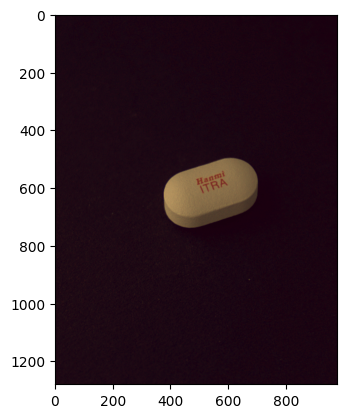

In [44]:
# 이미지를 로드합니다.
image_file_name = "K-009460_0_0_0_0_60_000_200"
pill_image = cv2.imread('C:\\Users\\ewqds\\Documents\\Pill_Data\\1.Training\\image\\K-009460\\'+ image_file_name + '.png', cv2.IMREAD_COLOR)
# 이미지가 성공적으로 불러와졌는지 확인
if pill_image is None:
    raise ValueError(f"이미지를 불러오는 데 실패했습니다.")

# Replace with the path to yresized_imageour JSON file
json_file_path = "C:\\Users\\ewqds\\Documents\\Pill_Data\\1.Training\\Label\\K-009460\\" + image_file_name + ".json"


# 잘라낸 알약 이미지를 시각화합니다.
plt.imshow(cv2.cvtColor(pill_image, cv2.COLOR_BGR2RGB))
plt.show()

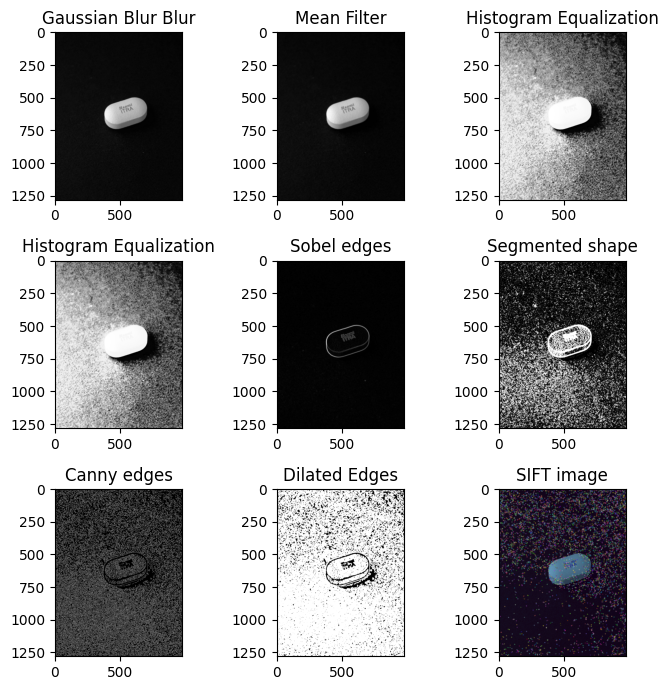

In [45]:
import os
import cv2
import json
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from matplotlib import pyplot as plt

import cv2
import numpy as np
import tensorflow as tf

# 이미지를 그레이스케일로 변환
gray = cv2.cvtColor(pill_image, cv2.COLOR_BGR2GRAY)

# 가우시안 필터를 적용하여 블러 처리
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# 평균 필터 적용
mean_filtered = cv2.blur(blurred, (5, 5))

# 히스토그램 평활화
equalized = cv2.equalizeHist(mean_filtered)

# Sobel 필터를 사용한 형태 감지
sobelx = cv2.Sobel(mean_filtered, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(mean_filtered, cv2.CV_64F, 0, 1, ksize=5)
sobel = cv2.magnitude(sobelx, sobely)
# 임계값 적용하여 이진 이미지 생성
_, thresholded = cv2.threshold(sobel, 50, 255, cv2.THRESH_BINARY)

# Canny 에지 검출기 사용
canny_edges = cv2.Canny(np.uint8(thresholded), 100, 200)
# Dilution 작업
dilated = cv2.dilate(canny_edges, np.ones((5,5), np.uint8), iterations=1)

# SIFT 및 MLBP (예시로 SIFT만 구현, MLBP는 OpenCV에서 직접적으로 지원하지 않음)
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(dilated, None)
# 결과 이미지 반환 (SIFT 키포인트로 표시된 이미지를 반환합니다)
result_image = cv2.drawKeypoints(pill_image, keypoints, None)

# cv2.imshow('Processed Image', processed_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# OpenCV로 이미지를 BGR에서 RGB로 변환
processed_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
# # 이미지 표시
# plt.imshow(processed_image_rgb)
# plt.title('Processed Image')
# plt.show()

# 결과 시각화
plt.figure(figsize=(7, 7))
plt.subplot(331), plt.imshow(blurred, cmap='gray'), plt.title('Gaussian Blur Blur')
plt.subplot(332), plt.imshow(mean_filtered, cmap='gray'), plt.title('Mean Filter')
plt.subplot(333), plt.imshow(equalized, cmap='gray'), plt.title('Histogram Equalization')
plt.subplot(334), plt.imshow(equalized, cmap='gray'), plt.title('Histogram Equalization')
plt.subplot(335), plt.imshow(sobel, cmap='gray'), plt.title('Sobel edges')
plt.subplot(336), plt.imshow(thresholded, cmap='gray'), plt.title('Segmented shape')
plt.subplot(337), plt.imshow(canny_edges, cmap='gray'), plt.title('Canny edges')
plt.subplot(338), plt.imshow(dilated, cmap='gray'), plt.title('Dilated Edges')
plt.subplot(339), plt.imshow(result_image, cmap='gray'), plt.title('SIFT image')


plt.tight_layout()
plt.show()  

# Model 정의

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# CNN 모델 정의
def build_cnn_model():
    model = models.Sequential()

    # 첫 번째 합성곱 계층과 풀링 계층 추가
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # 추가 합성곱 계층과 풀링 계층 추가
    model.add(layers.Conv2D(256, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # 더 많은 합성곱 계층 추가
    model.add(layers.Conv2D(384, (3, 3), activation='relu'))
    model.add(layers.Conv2D(384, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # 완전 연결 계층 추가
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # 마지막 분류 계층은 제외 (훈련 후 k-NN을 사용할 것이기 때문)

    return model

# 데이터를 훈련과 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 전처리: 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# CNN 모델 생성
num_classes = 7  # 알약 유형의 클래스 수
cnn_model = build_cnn_model()

# 모델 컴파일
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 특징 추출을 위한 CNN 모델 훈련
# 여기서는 예시이므로, 실제로는 데이터셋에 따라 훈련을 수행해야 합니다.
# cnn_model.fit(X_train_scaled, y_train, epochs=10, validation_split=0.2)
# 특징 벡터 생성을 위한 모델 구조 변경
# CNN을 통한 특징 추출
feature_extractor = models.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer(index=-3).output
)


X_train_features = feature_extractor.predict(X_train_scaled)
X_test_features = feature_extractor.predict(X_test_scaled)

# k-NN 분류기 생성 및 훈련
k = 5  # k-NN에서 사용할 이웃의 수
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_features, y_train)


# k-NN을 사용한 분류
y_pred = knn_classifier.predict(X_test_features)

# 분류 결과의 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'CNN + k-NN classifier accuracy: {accuracy * 100:.2f}%')

44/44 [==============================] - 5s 102ms/step
CNN + k-NN classifier accuracy: 94.79%


1/1 [==============================] - 0s 33ms/step
['K-010733']


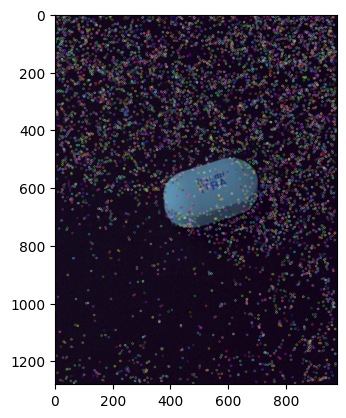

In [47]:
# 주어진 이미지 (processed_image)에 대해 특징 추출 후 k-NN을 사용하여 클래스를 예측합니다.
# CNN 모델로부터 특징 추출기를 만듭니다.
# feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)

# 이미지를 모델의 입력에 맞는 크기로 조정합니다. (예: 227x227)
input_image = cv2.resize(processed_image_rgb, (227, 227))
input_image = np.expand_dims(input_image, axis=0)  # 모델은 배치 차원을 기대합니다.

# CNN을 통해 특징을 추출합니다.
features = feature_extractor.predict(input_image)

# k-NN 분류기를 사용하여 클래스를 예측합니다.
predicted_class = knn_classifier.predict(features)
print(predicted_class)


# 잘라낸 알약 이미지를 시각화합니다.
plt.imshow(cv2.cvtColor(processed_image_rgb, cv2.COLOR_BGR2RGB))
plt.show()


In [1]:
y_pred.shape

NameError: name 'y_pred' is not defined

In [6]:
X_train.shape

(5529, 227, 227, 3)

In [3]:
# CNN 모델 정의
def create_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),
        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 모델 생성
input_shape = (227, 227, 3)  # 예시 입력 크기
num_classes = 7  # 올바른 약품 이미지, 잘못된 약품 이미지의 두 클래스
cnn_model = create_cnn(input_shape, num_classes)

# 컴파일 설정
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# 모델 요약
cnn_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)     

# 학습

In [4]:
# 데이터를 학습 및 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)

# 예측
predictions = cnn_model.predict(X_test)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\ewqds\anaconda3\envs\pillsgood\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ewqds\anaconda3\envs\pillsgood\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ewqds\anaconda3\envs\pillsgood\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ewqds\anaconda3\envs\pillsgood\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\ewqds\anaconda3\envs\pillsgood\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ewqds\anaconda3\envs\pillsgood\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 227, 227, 3), found shape=(None, 2, 227, 227, 3)


In [8]:
X_train.shape

(5529, 2, 227, 227, 3)

# 테스트(firebase storage에서 데이터 불러오기)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 평가

In [ ]:
# 테스트 데이터셋에 대한 예측을 수행합니다.
y_pred = knn.predict(X_test_features)

# 분류 결과를 평가합니다.
print(classification_report(y_test, y_pred))